In [1]:
import sys
import os
import functools
import scipy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm
import pickle
import math
import subprocess
import warnings

sys.path.insert(2, "/global/projecta/projectdirs/lux/data")
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/' )
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/aLib' )
import __init__ as S
import dp as dp
from scipy.optimize import OptimizeWarning

warnings.simplefilter("error", OptimizeWarning)
pylab.rcParams["figure.figsize"]=15,8
np.seterr(invalid='ignore')


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
#define a funtion do band's mean value and sigma calculation
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

def bandfit(x, y, bins=10, range=None, normed=False, weights=None):
    H, xedges,yedges = np.histogram2d(x, y, bins, range, normed, weights)
    log10xlist=[]
    mu=[]
    sigma=[]
    for ii in xrange(0,xedges.shape[0]-1):
        try:
            log10y = [0.5 * (yedges[i] + yedges[i+1]) for i in xrange(yedges.shape[0]-1)]
            Hx = H[ii,:]
            popt, pcov = sp.optimize.curve_fit(f, log10y, Hx)
            log10xlist.append(0.5 * (xedges[ii] + xedges[ii+1]))
            mu.append(popt[1])
            sigma.append(popt[2])
        except BaseException:
            print "Fitting data in bin ",ii,"failed."
    return(np.array(mu),np.abs(sigma),np.array(log10xlist))


In [3]:
def LoadXYZDependentEField(EFieldMap, NumxyzDependentEFieldVars = 8, MinLocationX = -24.0 ,NumPlanesX = 49, StepSizeX = 1. ,MinLocationY = -24.00 ,NumPlanesY = 49, StepSizeY = 1.,MinLocationZ = 5.8 ,NumPlanesZ = 49, StepSizeZ = 1.):
    EFieldMapMatrix = np.zeros((NumPlanesX,NumPlanesY,NumPlanesZ,NumxyzDependentEFieldVars))
    for ii in xrange(0,EFieldMap.shape[0]):
        xx = int(round((EFieldMap[ii,0]-MinLocationX)/StepSizeX))
        yy =  (int)(round((EFieldMap[ii,1]-MinLocationY)/StepSizeY))
        zz =  (int)(round((EFieldMap[ii,2]-MinLocationZ)/StepSizeZ))
        for vv in xrange(0,NumxyzDependentEFieldVars):
            if vv == 2:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv] 
            elif vv==6:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            else:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            
                
    return EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))

def GetXYZDependentElectricField(x,LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap
    xx =  int(round((x[0]-MinLocationX)/StepSizeX))
    yy =  int(round((x[1]-MinLocationY)/StepSizeY))
    if (xx<0 or xx>NumPlanesX-2 or yy<0 or yy>NumPlanesY-2):
#   if 0:
        return -100000
    else:
        distance2 = (x[0]-EFieldMapMatrix[xx,yy,0,0])**2+(x[1]-EFieldMapMatrix[xx,yy,0,1])**2
        for xxx in xrange(xx,xx+1):
            for yyy in xrange(yy,yy+1):                
                    if distance2 > ((x[0]-EFieldMapMatrix[xxx,yyy,0,0])**2+(x[1]-EFieldMapMatrix[xxx,yyy,0,1])**2):                                               
                        xx = xxx
                        yy = yyy
        zz=0
#        print xx,yy
        dist = np.abs(x[2]-EFieldMapMatrix[xx,yy,0,6])
#        print dist
        for zzz in xrange(0,NumPlanesZ):
            if np.abs(x[2]-EFieldMapMatrix[xx,yy,zzz,6])<dist:
                dist = np.abs(x[2]-EFieldMapMatrix[xx,yy,zzz,6])
                zz=zzz
    if ifprint:
        print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
        print "x,y,z,",EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2]
        print "S2x,S2y,t,",EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6]
    return EFieldMapMatrix[xx,yy,zz,3]

def GetXYZDependentElectricField_s2(x,LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    try:
        xx=0
        yy=0
        zz=0
        distance2 = 10000
        for xxx in xrange(0,NumPlanesX):
            for yyy in xrange(0,NumPlanesY):  
                 for zzz in xrange(0,NumPlanesZ):
                    if distance2 > ((x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2)+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.:                                               
                        xx = xxx
                        yy = yyy
                        zz = zzz
                        distance2 = (x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.
        if ifprint:
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print "x,y,z,",EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2]
            print "S2x,S2y,t,",EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6]

            print distance2
        return EFieldMapMatrix[xx,yy,zz,:]
    except :
        return -100000

In [39]:
def errorf(x,*args):
    (S2x,S2y,T),(x0,y0,z0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz) = args
    return (S2x - (s2x0 + (x[0]-x0)*ds2xdx + (x[1]-y0)*ds2xdy + (x[2]-z0)*ds2xdz))**2 \
            +(S2y - (s2y0 + (x[0]-x0)*ds2ydx + (x[1]-y0)*ds2ydy + (x[2]-z0)*ds2ydz))**2 \
            +(T - (t0 + (x[0]-x0)*dtdx + (x[1]-y0)*dtdy + (x[2]-z0)*dtdz))**2 

def intepolation(x,x0,f0,dfdx):
    x=np.array(x)
    x0 = np.array(x0)
    dfdx = np.array(dfdx)
    return f0+np.sum(dfdx*(x-x0))

def GetXYZFromXYZS2TDependentElectricField((S2x,S2y,DriftTime),LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    """
        This function is getting real x y z E from known S2x,S2y,DriftTime,fieldmap
        S2x, S2y in cm
        DriftTime in us
    """
    warnings.filterwarnings('error')
    
    try:
        
        if ifprint:
            print "S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns"
        xx=25
        yy=25
        zz=47
        attempt=200
        notsuccess = 1
        while((attempt > 0) and notsuccess):
            attempt-=1
            notsuccess = 0
            
            if S2x< EFieldMapMatrix[xx,yy,zz,4]:
                notsuccess = 1
                xx -= 1
                if ifprint:
                    print "xx--"
            elif S2x > EFieldMapMatrix[xx+1,yy,zz,4]:
                notsuccess = 1
                xx += 1
                if ifprint:
                    print "xx++"
            elif S2y< EFieldMapMatrix[xx,yy,zz,5]:
                notsuccess = 1
                yy -= 1
                if ifprint:
                    print "yy--"
            elif S2y > EFieldMapMatrix[xx,yy+1,zz,5]:
                notsuccess = 1
                yy += 1
                if ifprint:
                    print "yy++"
            elif DriftTime < EFieldMapMatrix[xx,yy,zz+1,6]:
                notsuccess = 1
                zz += 1
                if ifprint:
                    print "zz++"
            elif DriftTime > EFieldMapMatrix[xx,yy,zz,6]:
                notsuccess = 1
                zz -= 1
                if ifprint:
                    print "zz--"
            if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2:
                if ifprint:
                    print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
                return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
            if ifprint:
                print "attempt",attempt
                print "xx,yy,zz",xx,yy,zz
                print "Not success",notsuccess
        if ifprint:
            print "attempt finished"
        if attempt ==0 and ifprint:
            print "Did not find a point in the map matches with (S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns )"
            print "One of the closest point is (S2x =",EFieldMapMatrix[xx,yy,zz,4],"cm, S2y =",EFieldMapMatrix[xx,yy,zz,5],"cm, DriftTime =",EFieldMapMatrix[xx,yy,zz,6],"ns )"
            print "Check whether you are using the right field map and right S2x, S2y,S2z",attempt
        if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2 or\
            np.isnan(EFieldMapMatrix[xx,yy,zz,3])            :
            if ifprint:
                print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
            return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
        def dfdx(xx,yy,zz,num):
            dfdx = 1./4./StepSizeX*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]-EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdy = 1./4./StepSizeY*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     +EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]-EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdz = 1./4./StepSizeZ*(-EFieldMapMatrix[xx,yy,zz,num]+EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            return (dfdx,dfdy,dfdz)
        (ds2xdx,ds2xdy,ds2xdz) = dfdx(xx,yy,zz,4)
        (ds2ydx,ds2ydy,ds2ydz) = dfdx(xx,yy,zz,5)
        (dtdx,dtdy,dtdz)   = dfdx(xx,yy,zz,6)
        (xreal0,yreal0,zreal0) = (EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2])
        (s2x0,s2y0,t0) = (EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6])
           
        result= sp.optimize.fmin(errorf,x0=(xreal0,yreal0,zreal0),args = ((S2x,S2y,DriftTime),(xreal0,yreal0,zreal0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz)),disp=0)
        if ifprint:
            print result
        (xreal,yreal,zreal) = result
        E = intepolation((xreal,yreal,zreal),(xreal0,yreal0,zreal0),EFieldMapMatrix[xx,yy,zz,3],dfdx(xx,yy,zz,3))
        
        if ifprint:
            print "S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns" 
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7]

        
    except BaseException:
        return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    #return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    return (xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7])

In [5]:
Efieldmap = []

Efieldmap.append(np.loadtxt("/project/projectdirs/lux/users/weiji/Run4FieldMaps/v21_fields_20140903T1918_cp17059.txt"))
Efieldmap.append(np.loadtxt("/project/projectdirs/lux/users/weiji/Run4FieldMaps/v21_fields_20150226T1943_cp17072.txt"))
Efieldmap.append(np.loadtxt("/project/projectdirs/lux/users/weiji/Run4FieldMaps/v21_fields_20150928T2324_cp17544.txt"))
Efieldmap.append(np.loadtxt("/project/projectdirs/lux/users/weiji/Run4FieldMaps/v10_fields_20160222T1702_cp20511.txt"))

In [35]:
LoadEFieldMap = LoadXYZDependentEField(Efieldmap[0])
EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    

for aa in range(10):
    GetXYZFromXYZS2TDependentElectricField((raw_x_ts4[aa],raw_y_ts4[aa],drift_time_ts4[aa]),LoadEFieldMap,ifprint =1)

In [8]:
g1=[.104,.1,.1,.105]
g2=[19.15,20.35,19.55,18.3]

In [9]:
data=[]
sim=[]
datanamelist = ["TrData201409","TrData201502","TrData201509","TrData201602",]#"TrData201411","TrData201605",]
simnamelist = ["TrSim201409","TrSim201502","TrSim201509","TrSim201602",]

In [109]:
WantToSleep = 1

In [110]:
datalist=[]


In [111]:
for jj in range(len(datanamelist)):
#for jj in range(0,1):
    ts4 = np.load("/project/projectdirs/lux/users/weiji/data/"+datanamelist[jj]+".npy")[0]
    try:
        del ts4["spike_count"]
    except:
        print "There is no spike count in dataset "+datanamelist[jj]
        pass
    dic=S.S()
    LoadEFieldMap = LoadXYZDependentEField(Efieldmap[jj])
    mask_S1_ts4 = (ts4.pulse_classification==1)&(ts4.s1s2_pairing==1)
    mask_S2_ts4 = (ts4.pulse_classification==2)&(ts4.s1s2_pairing==1)
    S1_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S1_ts4).sum(0)
    S2_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S2_ts4).sum(0)
    raw_x_ts4 = (ts4.x_cm*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
    raw_y_ts4 = (ts4.y_cm*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
    #raw_x_del_ts4 = (ts4.x_cm_del*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
    #raw_y_del_ts4 = (ts4.y_cm_del*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
    
    drift_time_ts4 = (ts4.z_drift_samples*mask_S2_ts4).sum(0)/100.
    negative_drift_time_ts4 = [0-a for a in drift_time_ts4]
    raw_r_ts4 = (raw_x_ts4**2 + raw_y_ts4**2)**(1./2)
    # mask out only tritium_energies this is a mask on an entire event not a pulse
    # add a radial cut
    # add a drift time cut
    mask_tritium_energy_ts4 = (np.log10(S1_ts4) + 0.7*np.log10(S2_ts4)<4.8)& (np.log10(S1_ts4) + 0.7*np.log10(S2_ts4)>2.3) \
    &(np.log10(S1_ts4) - 2* np.log10(S2_ts4)<-5.) &(np.log10(S1_ts4) - 2* np.log10(S2_ts4)>-6.5)
    mask_drifttime_ts4 = (drift_time_ts4 <300.)& (drift_time_ts4 > 40.)
    #mask_xy_ts4 = (x_real_s2_ts4**2 +  y_real_s2_ts4**2 < 21.**2)
    tS1_ts4 = []
    tS2_ts4 = []
    traw_x_ts4 = []
    traw_y_ts4 = []
    traw_r_ts4 = []
    tdrift_time_ts4 = []
    x_del_ts4=[]
    y_del_ts4=[]
    Efield_s2_ts4=[]
    x_real_s2_ts4=[]
    y_real_s2_ts4=[]
    z_real_s2_ts4=[]
    #for aa in range(min(50000,len(mask_tritium_energy_ts4))):
    for aa in range(len(mask_tritium_energy_ts4)):
        if mask_tritium_energy_ts4[aa] == True and mask_drifttime_ts4[aa] ==True :
            if(WantToSleep):          
                temp =  GetXYZFromXYZS2TDependentElectricField((raw_x_ts4[aa],raw_y_ts4[aa],drift_time_ts4[aa]),LoadEFieldMap)

                mask_xy_ts4 = ((temp[0]**2 + temp[1]**2)< 21.**2)
                if mask_xy_ts4 ==True :
                    x_real_s2_ts4.append(temp[0])
                    y_real_s2_ts4.append(temp[1])
                    z_real_s2_ts4.append(temp[2])
                    Efield_s2_ts4.append(temp[3])
                    tS1_ts4.append(S1_ts4[aa])
                    tS2_ts4.append(S2_ts4[aa])
                    traw_x_ts4.append(raw_x_ts4[aa])
                    traw_y_ts4.append(raw_y_ts4[aa])
                    traw_r_ts4.append(raw_r_ts4[aa])
                    tdrift_time_ts4.append(drift_time_ts4[aa])
                    #x_del_ts4.append(raw_x_del_ts4[aa])
                    #y_del_ts4.append(raw_y_del_ts4[aa])
    dic.name = datanamelist[jj]
    dic.S1_t = np.array(tS1_ts4)
    dic.S2_t = np.array(tS2_ts4)
    dic.raw_x_t = np.array(traw_x_ts4)
    dic.raw_y_t = np.array(traw_y_ts4)
    dic.raw_r_t = np.array(traw_r_ts4)
    dic.drift_time_t= np.array(tdrift_time_ts4)
    dic.Efield_s2= np.array(Efield_s2_ts4)
    dic.x_real_s2= np.array(x_real_s2_ts4)
    dic.y_real_s2= np.array(y_real_s2_ts4)
    dic.z_real_s2= np.array(z_real_s2_ts4)
    dic.negative_drift_time_t = 0.- np.array(tdrift_time_ts4)
    dic.x_del = np.array(x_del_ts4)
    dic.y_del = np.array(y_del_ts4)
    g1_s4 = g1[jj]
    g2_s4 = g2[jj]
    W = 13.7/1000
    dic.S1_energy_t = W*np.array(tS1_ts4)/g1_s4
    dic.S2_energy_t = W*np.array(tS2_ts4)/g2_s4
    dic.Combined_energy_t = dic.S1_energy_t + dic.S2_energy_t
#    dic.Efield=[]
#    for ii in xrange(len(x_del_ts4)):
#        Efield_ts4.append(GetXYZDependentElectricField((x_del_ts4[ii],y_del_ts4[ii],drift_time_t_ts4[ii]),LoadEFieldMap))
#    Efield_ts4= np.array(Efield_ts4)

    datalist.append(dic)

There is no spike count in dataset TrData201509


In [ ]:
print datalist

[Dictionary contents:
                  FIELDS: TYPE                     CONTENTS
                  ------  ----                     --------
       Combined_energy_t: [(56814,) float32array], [  9.5561409   10.29616833   6...
               Efield_s2: [(56814,) float64array], [ 30312.42979188  23301.966661...
             S1_energy_t: [(56814,) float32array], [ 6.81332302  7.12318087  3.80...
                    S1_t: [(56814,) float32array], [ 51.72157669  54.07378006  28...
             S2_energy_t: [(56814,) float32array], [ 2.74281764  3.17298722  3.02...
                    S2_t: [(56814,) float32array], [ 3833.93847656  4435.23388672...
            drift_time_t: [(56814,) float64array], [  67.27  125.78  249.92  220....
                    name: [12 str],                TrData201409
   negative_drift_time_t: [(56814,) float64array], [ -67.27 -125.78 -249.92 -220....
                 raw_r_t: [(56814,) float32array], [ 10.24244308  10.30533123   9...
                 raw_x_t: [(5

In [ ]:
simlist=[]
for jj in range(len(simnamelist)):
#for jj in range(0,1):
    ts4 = np.load("/project/projectdirs/lux/users/weiji/data/"+simnamelist[jj]+".npy")[0]
    try:
        del ts4["spike_count"]
    except:
        print "There is no spike count in dataset "+simnamelist[jj]
        pass
    dic=S.S()
    LoadEFieldMap = LoadXYZDependentEField(Efieldmap[jj])
    mask_S1_ts4 = (ts4.pulse_classification==1)&(ts4.s1s2_pairing==1)
    mask_S2_ts4 = (ts4.pulse_classification==2)&(ts4.s1s2_pairing==1)
    S1_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S1_ts4).sum(0)
    S2_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S2_ts4).sum(0)
    raw_x_ts4 = (ts4.x_cm*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
    raw_y_ts4 = (ts4.y_cm*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
    #raw_x_del_ts4 = (ts4.x_cm_del*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
    #raw_y_del_ts4 = (ts4.y_cm_del*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
    
    drift_time_ts4 = (ts4.z_drift_samples*mask_S2_ts4).sum(0)/100.
    negative_drift_time_ts4 = [0-a for a in drift_time_ts4]
    raw_r_ts4 = (raw_x_ts4**2 + raw_y_ts4**2)**(1./2)
    # mask out only tritium_energies this is a mask on an entire event not a pulse
    # add a radial cut
    # add a drift time cut
    mask_tritium_energy_ts4 = (np.log10(S1_ts4) + 0.7*np.log10(S2_ts4)<4.8)& (np.log10(S1_ts4) + 0.7*np.log10(S2_ts4)>2.3) \
    &(np.log10(S1_ts4) - 2* np.log10(S2_ts4)<-5.) &(np.log10(S1_ts4) - 2* np.log10(S2_ts4)>-6.5)
    mask_drifttime_ts4 = (drift_time_ts4 <300.)& (drift_time_ts4 > 40.)
    #mask_xy_ts4 = (x_real_s2_ts4**2 +  y_real_s2_ts4**2 < 21.**2)
    tS1_ts4 = []
    tS2_ts4 = []
    traw_x_ts4 = []
    traw_y_ts4 = []
    traw_r_ts4 = []
    tdrift_time_ts4 = []
    x_del_ts4=[]
    y_del_ts4=[]
    Efield_s2_ts4=[]
    x_real_s2_ts4=[]
    y_real_s2_ts4=[]
    z_real_s2_ts4=[]
    #for aa in range(min(50000,len(mask_tritium_energy_ts4))):
    for aa in range(len(mask_tritium_energy_ts4)):
        if mask_tritium_energy_ts4[aa] == True and mask_drifttime_ts4[aa] ==True :
            if(WantToSleep):          
                temp =  GetXYZFromXYZS2TDependentElectricField((raw_x_ts4[aa],raw_y_ts4[aa],drift_time_ts4[aa]),LoadEFieldMap)

                mask_xy_ts4 = ((temp[0]**2 + temp[1]**2) < 21.**2)
                if mask_xy_ts4 == True :
                    x_real_s2_ts4.append(temp[0])
                    y_real_s2_ts4.append(temp[1])
                    z_real_s2_ts4.append(temp[2])
                    Efield_s2_ts4.append(temp[3])
                    tS1_ts4.append(S1_ts4[aa])
                    tS2_ts4.append(S2_ts4[aa])
                    traw_x_ts4.append(raw_x_ts4[aa])
                    traw_y_ts4.append(raw_y_ts4[aa])
                    traw_r_ts4.append(raw_r_ts4[aa])
                    tdrift_time_ts4.append(drift_time_ts4[aa])
                    #x_del_ts4.append(raw_x_del_ts4[aa])
                    #y_del_ts4.append(raw_y_del_ts4[aa])
    dic.name = simnamelist[jj]
    dic.S1_t = np.array(tS1_ts4)
    dic.S2_t = np.array(tS2_ts4)
    dic.raw_x_t = np.array(traw_x_ts4)
    dic.raw_y_t = np.array(traw_y_ts4)
    dic.raw_r_t = np.array(traw_r_ts4)
    dic.drift_time_t= np.array(tdrift_time_ts4)
    dic.Efield_s2= np.array(Efield_s2_ts4)
    dic.x_real_s2= np.array(x_real_s2_ts4)
    dic.y_real_s2= np.array(y_real_s2_ts4)
    dic.z_real_s2= np.array(z_real_s2_ts4)
    dic.negative_drift_time_t = 0.- np.array(tdrift_time_ts4)
    dic.x_del = np.array(x_del_ts4)
    dic.y_del = np.array(y_del_ts4)
    g1_s4 = g1[jj]
    g2_s4 = g2[jj]
    W = 13.7/1000
    dic.S1_energy_t = W*np.array(tS1_ts4)/g1_s4
    dic.S2_energy_t = W*np.array(tS2_ts4)/g2_s4
    dic.Combined_energy_t = dic.S1_energy_t + dic.S2_energy_t
#   dic.Efield=[]
#    for ii in xrange(len(x_del_ts4)):
#        Efield_ts4.append(GetXYZDependentElectricField((x_del_ts4[ii],y_del_ts4[ii],drift_time_t_ts4[ii]),LoadEFieldMap))
#    Efield_ts4= np.array(Efield_ts4)

    simlist.append(dic)

In [ ]:
print simlist

In [ ]:
WantToSleep = 0

In [ ]:
np.save("/global/project/projectdirs/lux/users/weiji/data/TrDatalist", np.array(datalist))

In [ ]:
np.save("/global/project/projectdirs/lux/users/weiji/data/TrSimlist", np.array(simlist))

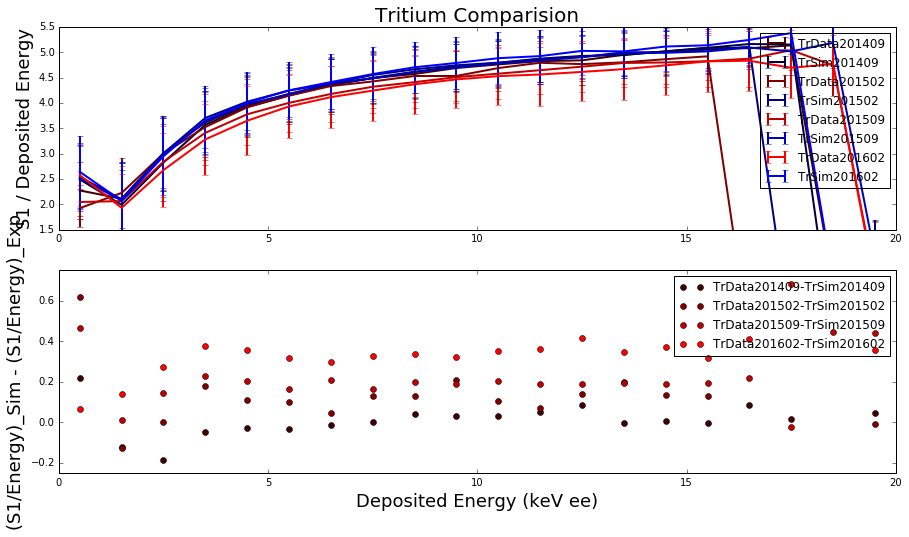

In [95]:
# light yield
plt.figure(1001)
databandfit=[]
simbandfit=[]
ax0 = plt.subplot(2, 1, 1)
for zz in range(4):
    databandfit.append(bandfit(datalist[zz]["Combined_energy_t"], datalist[zz]["S1_t"]/datalist[zz]["Combined_energy_t"],\
                               range=[[0,20],[0,7]],bins=(20,20),))
    simbandfit.append(bandfit(simlist[zz]["Combined_energy_t"], simlist[zz]["S1_t"]/simlist[zz]["Combined_energy_t"],\
                               range=[[0,20],[0,7]],bins=(20,20),))
    plt.errorbar(databandfit[zz][2],databandfit[zz][0],databandfit[zz][1],lw=2, 
                 color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.errorbar(simbandfit[zz][2],simbandfit[zz][0],simbandfit[zz][1],lw=2, \
                 color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(0,20.)
plt.ylim(1.5,5.5)
plt.legend()
#plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.ylabel("S1 / Deposited Energy", fontsize=18)
plt.title("Tritium Comparision"  , fontsize=20)

ax1 = plt.subplot(2, 1, 2)
for zz in range(len(datanamelist)):
    inds1 = np.in1d(simbandfit[zz][2],databandfit[zz][2])
    inds0 = np.in1d(databandfit[zz][2],simbandfit[zz][2])
    ax1.plot(simbandfit[zz][2][inds1],simbandfit[zz][0][inds1]-databandfit[zz][0][inds0],"o",\
             color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),lw=2, \
             label=datanamelist[zz]+"-"+simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(0,20.)
plt.ylim(-0.25,0.75)
plt.legend()
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.ylabel("(S1/Energy)_Sim - (S1/Energy)_Exp", fontsize=18)
#plt.title("Tritium Comparision"  , fontsize=20)

Fitting data in bin  32 failed.
Fitting data in bin  40 failed.
Fitting data in bin  40 failed.
Fitting data in bin  42 failed.
Fitting data in bin  42 failed.


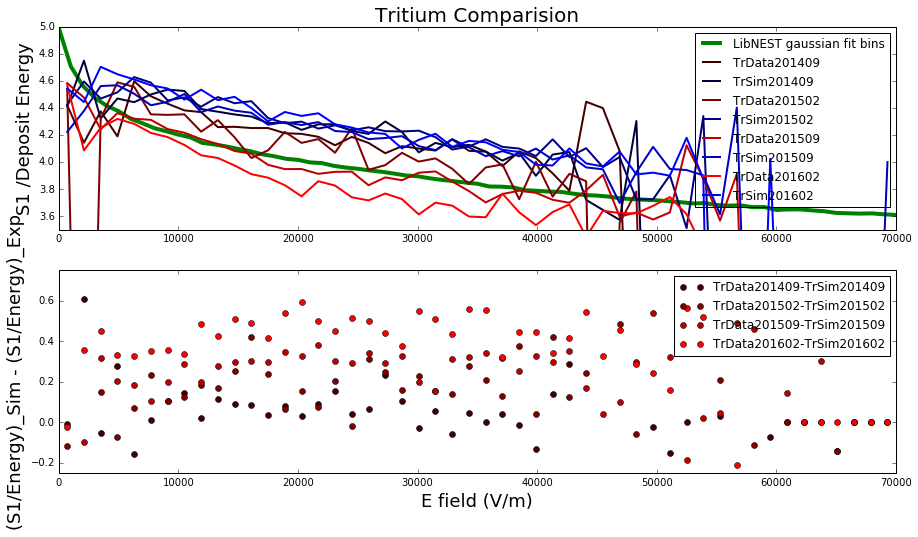

In [96]:
# light yield
plt.figure(1001)
databandfitefield=[]
simbandfitefield=[]
bandfits=np.load("LYgaussian.npy")
ax0 = plt.subplot(2, 1, 1)
plt.plot(bandfits[2]*100.,bandfits[0],lw=4, color="g",label="LibNEST gaussian fit bins")
for zz in range(len(datanamelist)):
    databandfitefield.append(bandfit(datalist[zz]["Efield_s2"][~np.isnan(datalist[zz]["Efield_s2"])],\
            datalist[zz]["S1_t"][~np.isnan(datalist[zz]["Efield_s2"])]/datalist[zz]["Combined_energy_t"][~np.isnan(datalist[zz]["Efield_s2"])],\
                               range=[[0,70000],[0,8]],bins=(50,50),))
    simbandfitefield.append(bandfit(simlist[zz]["Efield_s2"][~np.isnan(simlist[zz]["Efield_s2"])],\
            simlist[zz]["S1_t"][~np.isnan(simlist[zz]["Efield_s2"])]/simlist[zz]["Combined_energy_t"][~np.isnan(simlist[zz]["Efield_s2"])],\
                               range=[[0,70000],[0,8]],bins=(50,50),))
    #plt.errorbar(databandfitefield[zz][2],databandfitefield[zz][0],databandfitefield[zz][1],lw=2, \
                 #color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    #plt.errorbar(simbandfitefield[zz][2],simbandfitefield[zz][0],simbandfitefield[zz][1],lw=2, \
                 #color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.plot(databandfitefield[zz][2],databandfitefield[zz][0],lw=2, \
                 color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.plot(simbandfitefield[zz][2],simbandfitefield[zz][0],lw=2, \
                 color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(0,70000.)
plt.ylim(3.5,5.0)
plt.legend()
#plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1 /Deposit Energy", fontsize=18)
plt.title("Tritium Comparision"  , fontsize=20)
ax1 = plt.subplot(2, 1, 2)
for zz in range(len(datanamelist)):
    inds1 = np.in1d(simbandfitefield[zz][2],databandfitefield[zz][2])
    inds0 = np.in1d(databandfitefield[zz][2],simbandfitefield[zz][2])
    ax1.plot(simbandfitefield[zz][2][inds1],simbandfitefield[zz][0][inds1]-databandfitefield[zz][0][inds0],"o",\
             color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),lw=2, \
             label=datanamelist[zz]+"-"+simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(0,70000.)
plt.ylim(-0.25,0.75)
plt.legend()
plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("(S1/Energy)_Sim - (S1/Energy)_Exp", fontsize=18)
#plt.title("Tritium Comparision"  , fontsize=20)

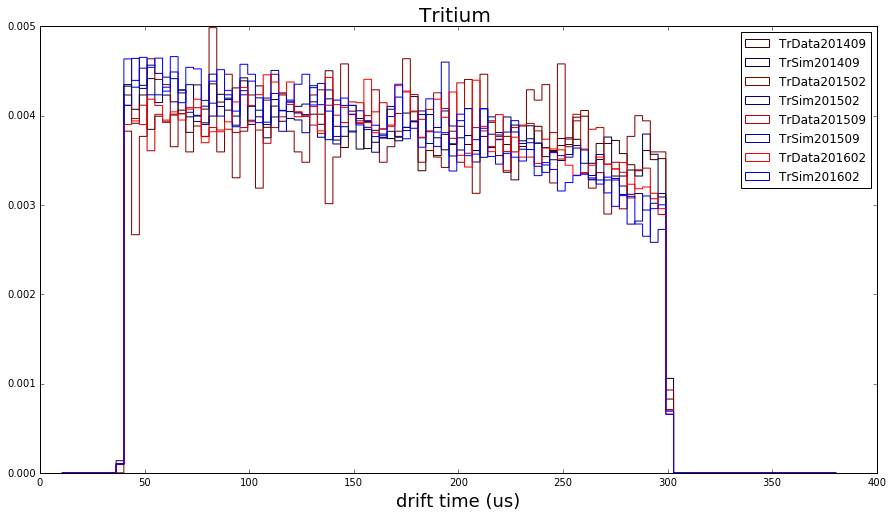

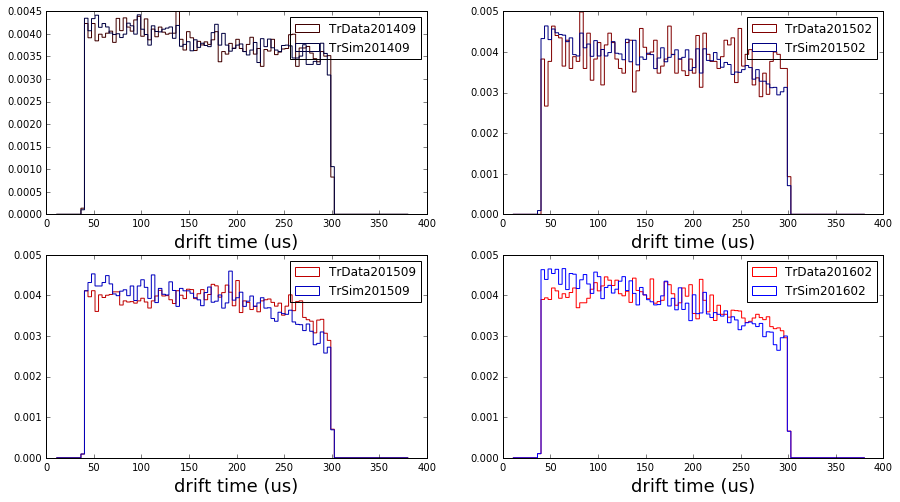

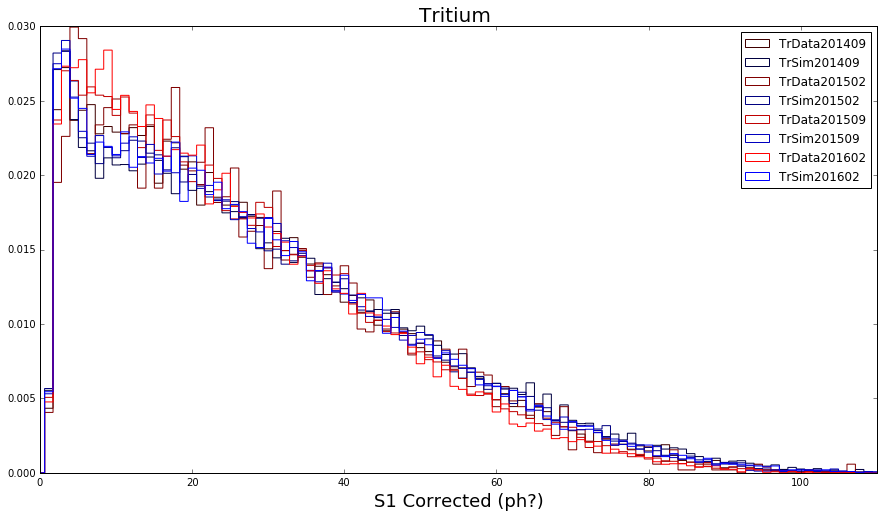

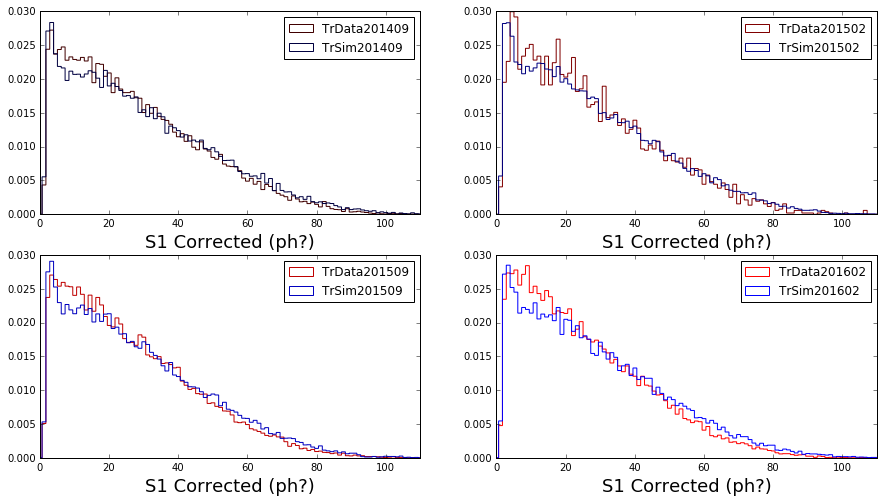

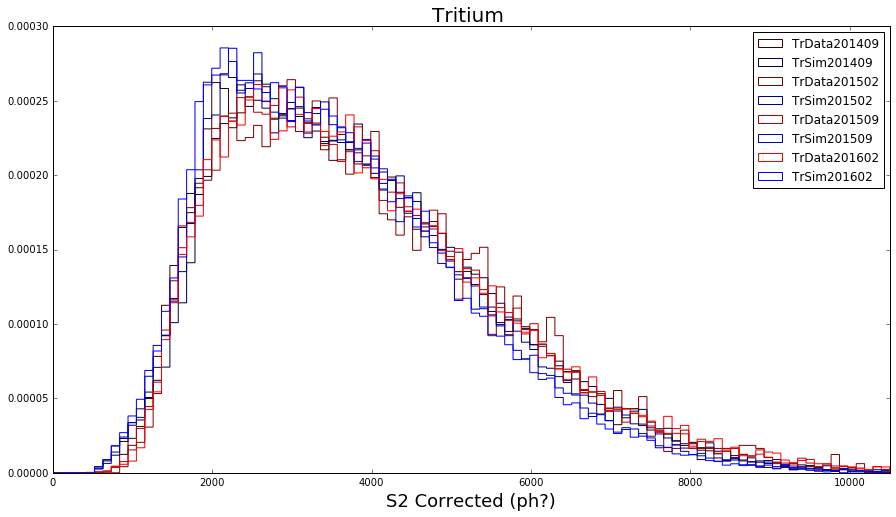

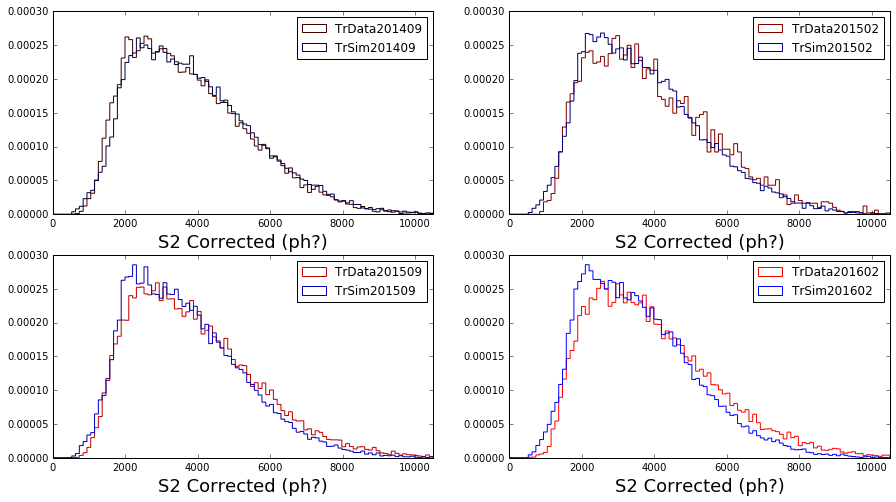

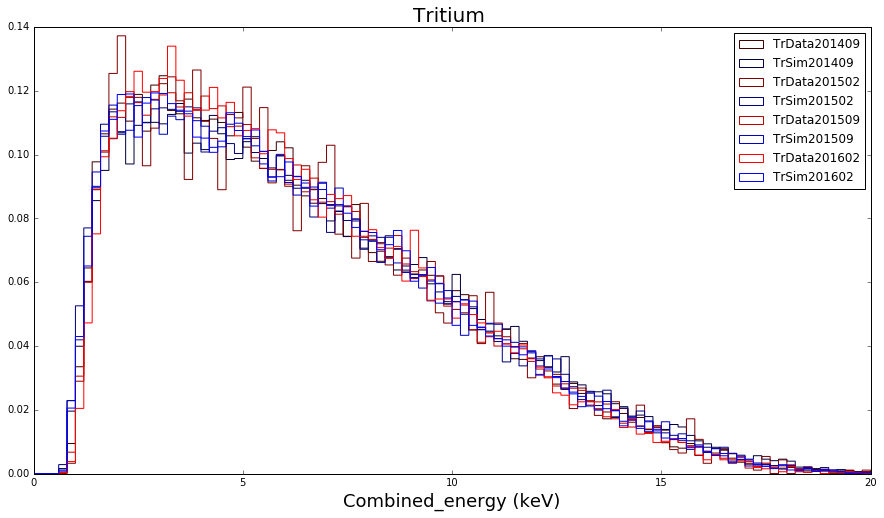

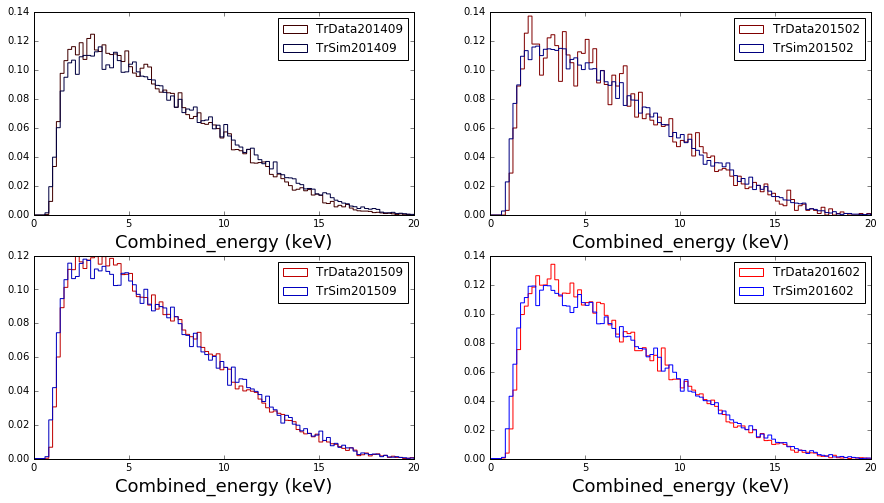

In [97]:
# drift time histogram
plt.figure(1090)
#plt.hist(drift_time_t_ts4, range=[10.5,380.5], bins=100)
for zz in range(4):
    plt.hist(datalist[zz]["drift_time_t"], range=[10.5,380.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["drift_time_t"], range=[10.5,380.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.xlabel("drift time (us)",fontsize=18)
plt.legend()
plt.title("Tritium ", fontsize=20)

plt.figure(1091)
#plt.hist(drift_time_t_ts4, range=[10.5,380.5], bins=100)

for zz in range(4):
    ax0 = plt.subplot(2, 2, zz+1)
    plt.hist(datalist[zz]["drift_time_t"], range=[10.5,380.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["drift_time_t"], range=[10.5,380.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.legend()
    plt.xlabel("drift time (us)",fontsize=18)
#plt.title("Tritium ", fontsize=20)

# Corrected S1
plt.figure(1100)
#plt.hist(S1_t_ts4, range=[-0.5,110.5], bins=111)
for zz in range(4):
    plt.hist(datalist[zz]["S1_t"], range=[-0.5,110.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["S1_t"], range=[-0.5,110.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.xlim(0,110)
    plt.xlabel("S1 Corrected (ph?)",fontsize=18)
plt.legend()
plt.title("Tritium ", fontsize=20)

plt.figure(1101)
#plt.hist(S1_t_ts4, range=[-0.5,110.5], bins=111)
for zz in range(4):
    ax0 = plt.subplot(2, 2, zz+1)
    plt.hist(datalist[zz]["S1_t"], range=[-0.5,110.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["S1_t"], range=[-0.5,110.5], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.xlim(0,110)
    plt.xlabel("S1 Corrected (ph?)",fontsize=18)
    plt.legend()
#plt.title("Tritium ", fontsize=20)

# Corrected S2
plt.figure(1200)
for zz in range(4):
    plt.hist(datalist[zz]["S2_t"], range=[0.,10500.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["S2_t"], range=[0.,10500.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.xlim(0,10500.)
plt.legend()
plt.xlabel("S2 Corrected (ph?)",fontsize=18)
plt.title("Tritium ", fontsize=20)

plt.figure(1202)
for zz in range(4):
    ax0 = plt.subplot(2, 2, zz+1)
    plt.hist(datalist[zz]["S2_t"], range=[0.,10500.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["S2_t"], range=[0.,10500.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.xlim(0,10500.)
    plt.legend()
    plt.xlabel("S2 Corrected (ph?)",fontsize=18)
#plt.title("Tritium ", fontsize=20)

#Combined_energy_t
plt.figure(1300)
for zz in range(4):
    plt.hist(datalist[zz]["Combined_energy_t"], range=[0.,20.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["Combined_energy_t"], range=[0.,20.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.xlim(0,20.)
plt.legend()
plt.xlabel("Combined_energy (keV)",fontsize=18)
plt.title("Tritium ", fontsize=20)

plt.figure(1301)
for zz in range(4):
    ax0 = plt.subplot(2, 2, zz+1)
    plt.hist(datalist[zz]["Combined_energy_t"], range=[0.,20.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.hist(simlist[zz]["Combined_energy_t"], range=[0.,20.], bins=100, histtype="step", normed=True, \
             color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
    plt.xlim(0,20.)
    plt.legend()
    plt.xlabel("Combined_energy (keV)",fontsize=18)
#plt.title("Tritium ", fontsize=20)

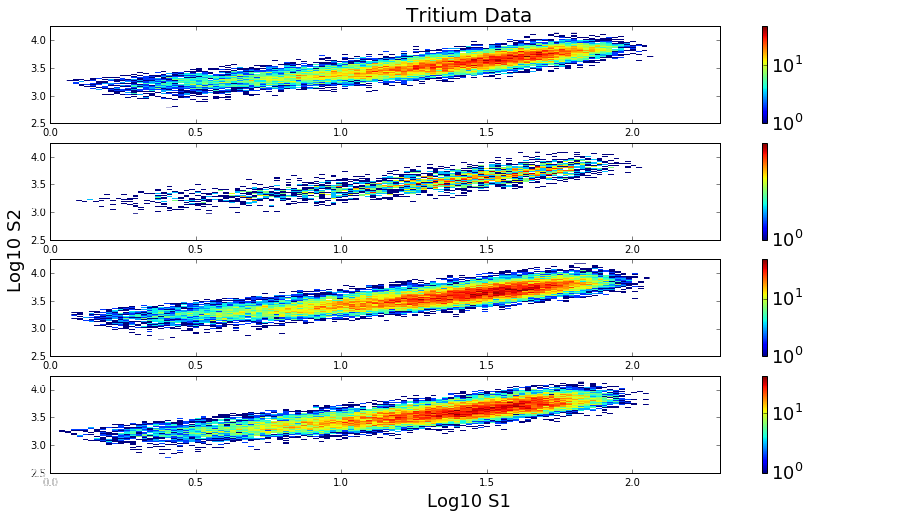

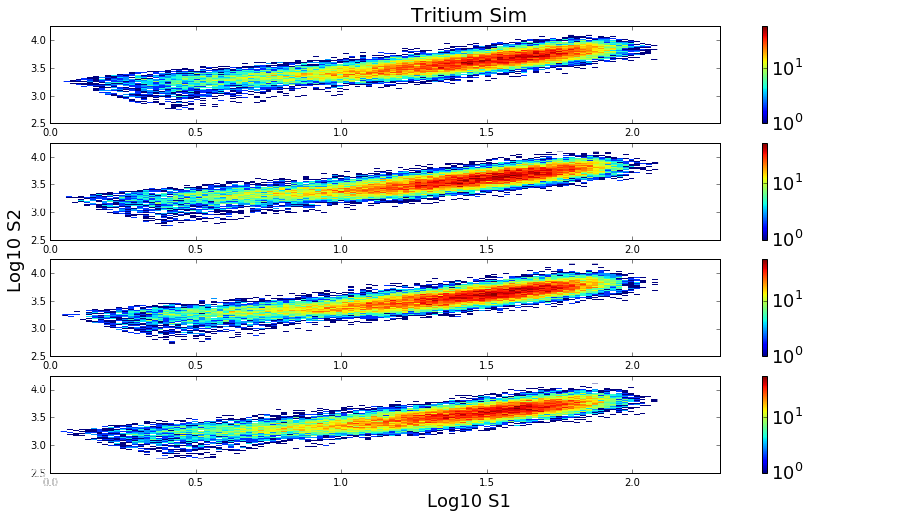

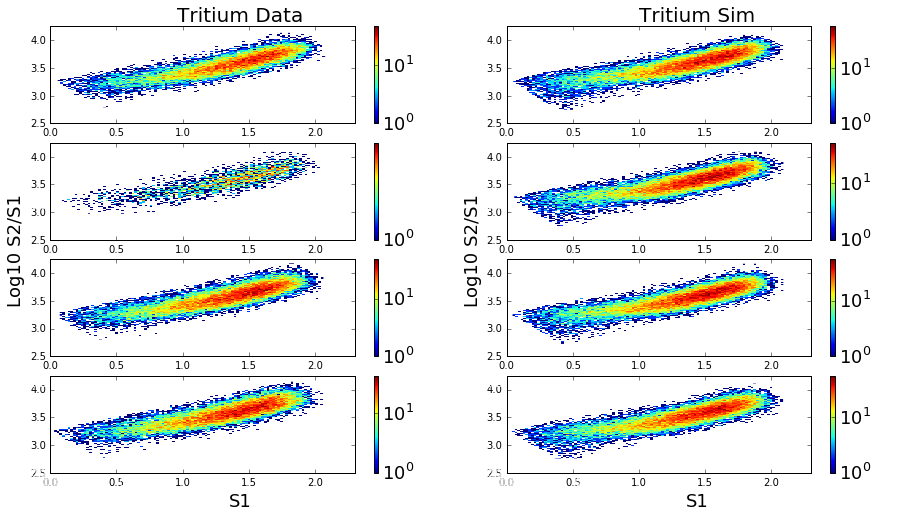

In [98]:
# S2 vs S1
fig = plt.figure(10)
for zz in range(4):
    ax = plt.subplot(4, 1, zz+1)
    plt.hist2d(np.log10(datalist[zz]["S1_t"]),np.log10(datalist[zz]["S2_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,2.3)
    plt.ylim(2.5,4.25)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("Log10 S1", fontsize=18)
ax.set_ylabel("Log10 S2", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)

fig = plt.figure(11)
for zz in range(4):
    ax = plt.subplot(4, 1, zz+1)
    plt.hist2d(np.log10(simlist[zz]["S1_t"]),np.log10(simlist[zz]["S2_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,2.3)
    plt.ylim(2.5,4.25)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("Log10 S1", fontsize=18)
ax.set_ylabel("Log10 S2", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)

fig = plt.figure(12)
for zz in range(4):
    ax = plt.subplot(4, 2, 2*zz+1)
    plt.hist2d(np.log10(datalist[zz]["S1_t"]),np.log10(datalist[zz]["S2_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,2.3)
    plt.ylim(2.5,4.25)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
    ax = plt.subplot(4, 2, 2*zz+2)
    plt.hist2d(np.log10(simlist[zz]["S1_t"]),np.log10(simlist[zz]["S2_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,2.3)
    plt.ylim(2.5,4.25)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(121)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel"Log10 S1", fontsize=18)
ax.set_ylabel("Log10 S2", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)
ax = fig.add_subplot(122)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)





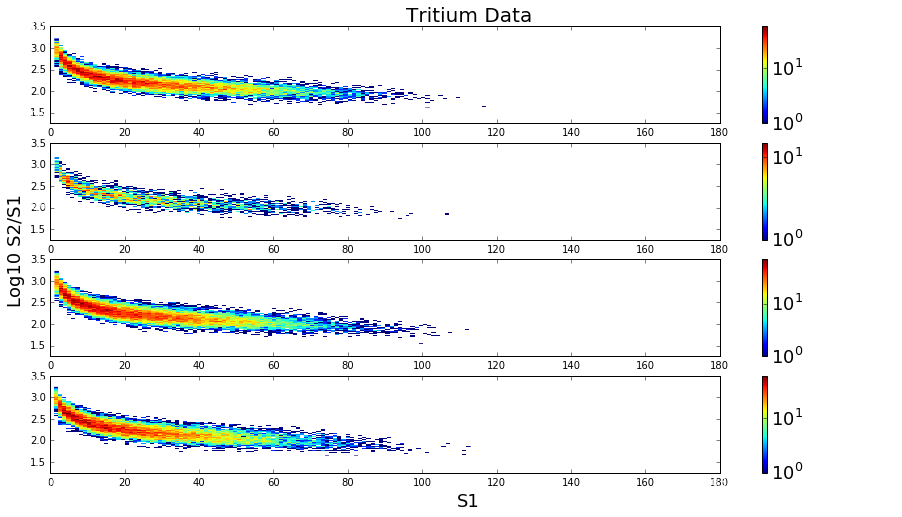

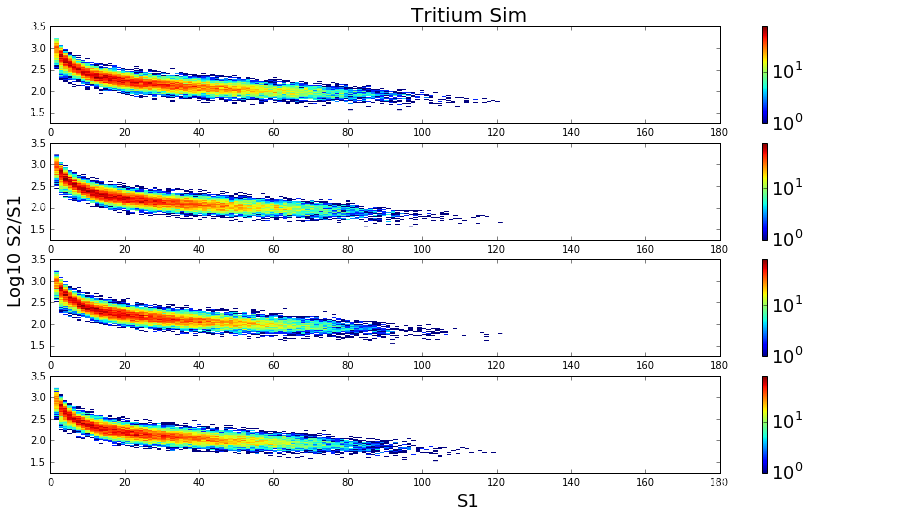

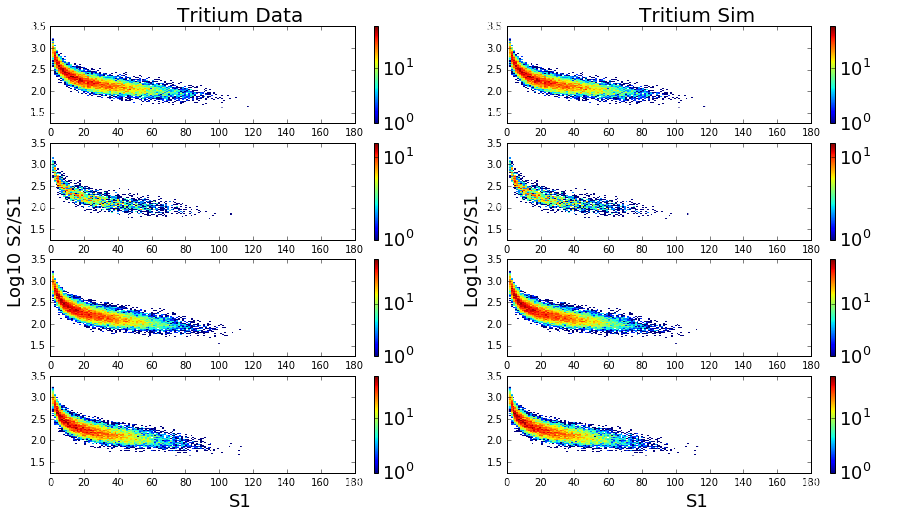

In [99]:
# Traditional band plot
fig = plt.figure(20)
for zz in range(4):
    ax = plt.subplot(4, 1, zz+1)
    plt.hist2d(datalist[zz]["S1_t"],np.log10(datalist[zz]["S2_t"])-np.log10(datalist[zz]["S1_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,180.)
    plt.ylim(1.25,3.5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)

# Traditional band plot
fig = plt.figure(21)
for zz in range(4):
    ax = plt.subplot(4, 1, zz+1)
    plt.hist2d(simlist[zz]["S1_t"],np.log10(simlist[zz]["S2_t"])-np.log10(simlist[zz]["S1_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,180.)
    plt.ylim(1.25,3.5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)

# Traditional band plot
fig = plt.figure(22)
for zz in range(4):
    ax = plt.subplot(4, 2, 2*zz+1)
    plt.hist2d(datalist[zz]["S1_t"],np.log10(datalist[zz]["S2_t"])-np.log10(datalist[zz]["S1_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,180.)
    plt.ylim(1.25,3.5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
    ax = plt.subplot(4, 2, 2*zz+2)
    plt.hist2d(datalist[zz]["S1_t"],np.log10(datalist[zz]["S2_t"])-np.log10(datalist[zz]["S1_t"]),bins=(100,100),norm=LogNorm())
    plt.xlim(0.,180.)
    plt.ylim(1.25,3.5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18)
ax = fig.add_subplot(121)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)
ax = fig.add_subplot(122)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)

Fitting data in bin  43 failed.
Fitting data in bin  44 failed.
Fitting data in bin  45 failed.
Fitting data in bin  41 failed.
Fitting data in bin  45 failed.
Fitting data in bin  43 failed.
Fitting data in bin  45 failed.
Fitting data in bin  45 failed.


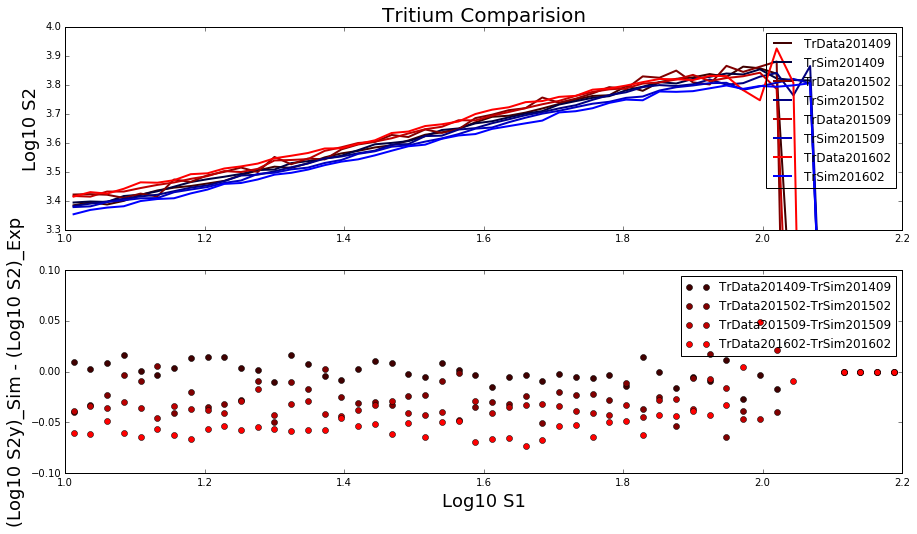

In [100]:
# S2 vs S1
plt.figure(1101)
databandfitlogs1logs2=[]
simbandfitlogs1logs2=[]
#bandfits=np.load("LYgaussian.npy")
ax0 = plt.subplot(2, 1, 1)
#plt.plot(bandfits[2]*100.,bandfits[0],lw=4, color="g",label="LibNEST gaussian fit bins")
for zz in range(len(datanamelist)):
    databandfitlogs1logs2.append(bandfit(np.log10(datalist[zz]["S1_t"]),np.log10(datalist[zz]["S2_t"]),\
                                         range=[[1,2.2],[2.8,4.3]],bins=(50,50),))
    simbandfitlogs1logs2.append(bandfit(np.log10(simlist[zz]["S1_t"]),np.log10(simlist[zz]["S2_t"]),\
                                        range=[[1,2.2],[2.8,4.3]],bins=(50,50),))
    plt.plot(databandfitlogs1logs2[zz][2],databandfitlogs1logs2[zz][0],lw=2, \
                 color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),label= datanamelist[zz])
    plt.plot(simbandfitlogs1logs2[zz][2],simbandfitlogs1logs2[zz][0],lw=2, \
                 color= float(zz+1)/float(len(datanamelist))* np.array((0.0,0.0,1.0)),label= simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(1,2.2)
plt.ylim(3.3,4.0)
plt.legend()
#plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("Log10 S2", fontsize=18)
plt.title("Tritium Comparision"  , fontsize=20)
ax1 = plt.subplot(2, 1, 2)
for zz in range(len(datanamelist)):
    inds1 = np.in1d(simbandfitlogs1logs2[zz][2],databandfitlogs1logs2[zz][2])
    inds0 = np.in1d(databandfitlogs1logs2[zz][2],simbandfitlogs1logs2[zz][2])
    ax1.plot(simbandfitlogs1logs2[zz][2][inds1],simbandfitlogs1logs2[zz][0][inds1]-databandfitlogs1logs2[zz][0][inds0],"o",\
             color= float(zz+1)/float(len(datanamelist))*np.array((1.0,0.0,0.0)),lw=2, \
             label=datanamelist[zz]+"-"+simnamelist[zz])
plt.legend(loc=0,fontsize=35)
plt.xlim(1,2.2)
plt.ylim(-0.1,0.1)
plt.legend()
plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("(Log10 S2y)_Sim - (Log10 S2)_Exp", fontsize=18)
#plt.title("Tritium Comparision"  , fontsize=20)

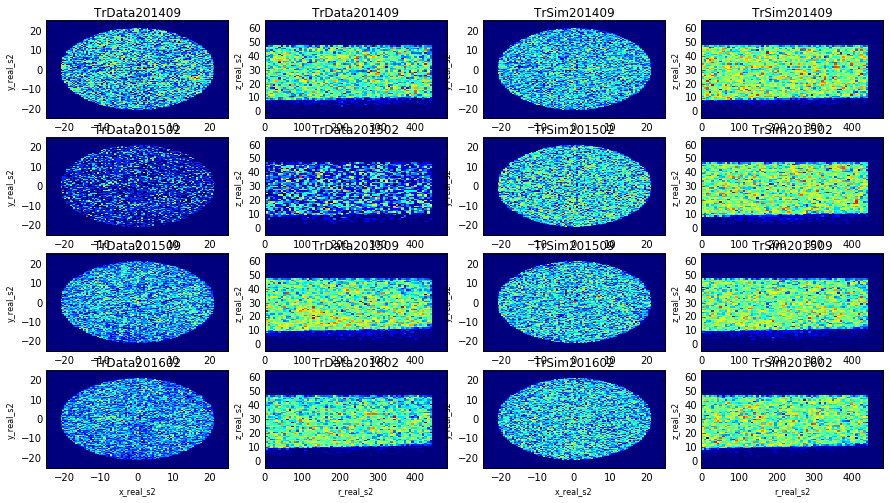

In [101]:
# combined xyz plot
plt.figure(80)

#plt.plot(bandfits[2]*100.,bandfits[0],lw=4, color="g",label="LibNEST gaussian fit bins")
for zz in range(len(datanamelist)):
    ax0 = plt.subplot(4, 4, 4*zz+1,figsize=(2,2))
    plt.hist2d(datalist[zz]["x_real_s2"],datalist[zz]["y_real_s2"],range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= datanamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("x_real_s2",fontsize=8)
    plt.ylabel("y_real_s2",fontsize=8)
    plt.title(datanamelist[zz])
    
    ax0 = plt.subplot(4, 4, 4*zz+2)
    plt.hist2d((datalist[zz]["x_real_s2"]**2+datalist[zz]["y_real_s2"]**2),datalist[zz]["z_real_s2"],\
               range=[[0,22.**2],[-5.,65.]],bins=(70,70), normed=True,label= datanamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("r_real_s2",fontsize=8)
    plt.ylabel("z_real_s2",fontsize=8)
    plt.title(datanamelist[zz])
    
    ax0 = plt.subplot(4, 4, 4*zz+3,figsize=(2,2))
    plt.hist2d(simlist[zz]["x_real_s2"],simlist[zz]["y_real_s2"],range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= simnamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("x_real_s2",fontsize=8)
    plt.ylabel("y_real_s2",fontsize=8)
    plt.title(simnamelist[zz])    

    ax0 = plt.subplot(4, 4, 4*zz+4)
    plt.hist2d((simlist[zz]["x_real_s2"]**2+simlist[zz]["y_real_s2"]**2),simlist[zz]["z_real_s2"],\
               range=[[0,22.**2],[-5.,65.]],bins=(70,70), normed=True,label= simnamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("r_real_s2",fontsize=8)
    plt.ylabel("z_real_s2",fontsize=8)
    plt.title(simnamelist[zz])
    
ax = fig.add_subplot(121)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)
ax = fig.add_subplot(122)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)

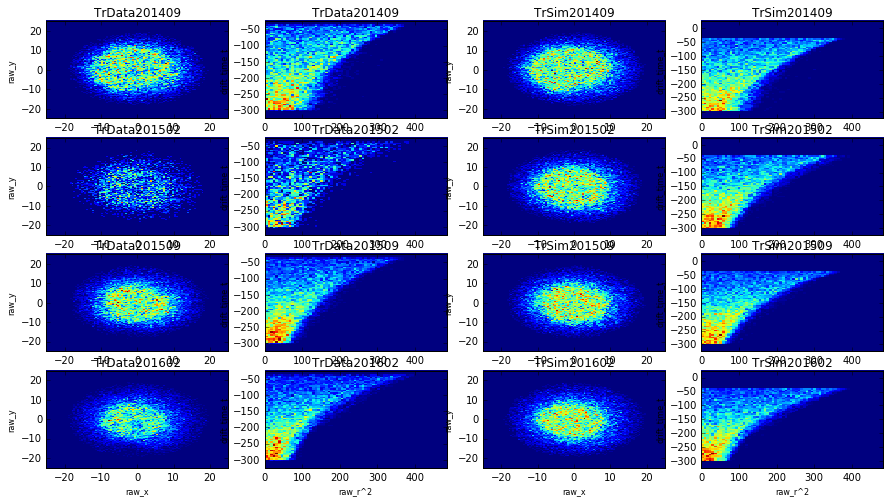

In [102]:
# combined xyz plot
plt.figure(81)

#plt.plot(bandfits[2]*100.,bandfits[0],lw=4, color="g",label="LibNEST gaussian fit bins")
for zz in range(len(datanamelist)):
    ax0 = plt.subplot(4, 4, 4*zz+1,figsize=(2,2))
    plt.hist2d(datalist[zz]["raw_x_t"],datalist[zz]["raw_y_t"],range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= datanamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("raw_x",fontsize=8)
    plt.ylabel("raw_y",fontsize=8)
    plt.title(datanamelist[zz])
    
    ax0 = plt.subplot(4, 4, 4*zz+2)
    plt.hist2d((datalist[zz]["raw_x_t"]**2+datalist[zz]["raw_y_t"]**2),-datalist[zz]["drift_time_t"],\
               range=[[0,22.**2],[-325.,-25.]],bins=(70,70), normed=True,label= datanamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("raw_r^2",fontsize=8)
    plt.ylabel("drift_time_t",fontsize=8)
    plt.title(datanamelist[zz])
    
    ax0 = plt.subplot(4, 4, 4*zz+3,figsize=(2,2))
    plt.hist2d(simlist[zz]["raw_x_t"],simlist[zz]["raw_y_t"],range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= simnamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("raw_x",fontsize=8)
    plt.ylabel("raw_y",fontsize=8)
    plt.title(simnamelist[zz])    

    ax0 = plt.subplot(4, 4, 4*zz+4)
    plt.hist2d((simlist[zz]["raw_x_t"]**2+simlist[zz]["raw_y_t"]**2),-simlist[zz]["drift_time_t"],\
               range=[[0,22.**2],[-325.,25.]],bins=(70,70), normed=True,label= simnamelist[zz])
#    cbar = plt.colorbar()
    
    plt.xlabel("raw_r^2",fontsize=8)
    plt.ylabel("drift_time_t",fontsize=8)
    plt.title(simnamelist[zz])
    
ax = fig.add_subplot(121)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Data", fontsize=20)
ax = fig.add_subplot(122)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel("S1", fontsize=18)
ax.set_ylabel("Log10 S2/S1", fontsize=18)
ax.set_title("Tritium Sim", fontsize=20)
    

In [103]:
np.where(np.isnan(datalist[zz]["z_real_s2"]))
print(len(datalist[zz]["x_real_s2"])),(len(datalist[zz]["y_real_s2"])),(len(datalist[zz]["z_real_s2"]))

26675 26675 26675


In [ ]:
# Corrected S1
plt.figure(991)
plt.hist(S2_t_ts4[np.where(np.abs(S1_t_ts4-3)<0.5)], range=[1000,4000], bins=111)
#plt.xlim(0,110)
plt.xlabel("S2 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)
# Corrected S1
plt.figure(992)
plt.hist(S2_ss4[np.where(np.abs(S1_ss4-3)<0.5)], range=[1000,4000], bins=111)
#plt.xlim(0,110)
plt.xlabel("S2 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)
# Corrected S1
plt.figure(993)
plt.hist(z_real_s2_ts4[np.where(np.abs(S1_t_ts4-3)<0.5)], range=[0,60], bins=100)
#plt.xlim(0,110)
plt.xlabel("z",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)
# Corrected S1
plt.figure(994)
plt.hist(z_real_s2_ss4[np.where(np.abs(S1_ss4-3)<0.5)], range=[0,60], bins=100)
#plt.xlim(0,110)
plt.xlabel("z",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

In [27]:
from scipy.stats import ks_2samp
ks_2samp(drift_time_ss4[np.where(np.abs(drift_time_ss4-195.5)<185.5)]/np.linalg.norm(drift_time_ss4[np.where(np.abs(drift_time_ss4-195.5)<185.5)]),\
         drift_time_t_ts4[np.where(np.abs(drift_time_t_ts4-195.5)<185.5)]/np.linalg.norm(drift_time_t_ts4[np.where(np.abs(drift_time_t_ts4-195.5)<185.5)]))

NameError: name 'drift_time_ss4' is not defined

In [127]:
S1_ss4[~np.isnan(Efield_s2_ss4)]/Combined_energy_ss4[~np.isnan(Efield_s2_ss4)]


array([ 2.96956229,  4.96541452,  2.30777454, ...,  4.66737986,
        1.047194  ,  2.42334938], dtype=float32)

In [128]:
len(S1_ss4)

51353

In [129]:
S1_ss4[~np.isnan(Efield_s2_ss4)]

array([  5.25387859,  35.68699265,   2.68518496, ...,  62.5190239 ,
         1.86111939,   9.08466053], dtype=float32)

In [130]:
~np.isnan(Efield_s2_ss4)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [131]:
Efield_s2_ss4

array([  8351.17299876,   7433.06432366,   2199.08947548, ...,
        10591.79493914,  15674.88737374,  37214.09925588])

In [133]:
filedir = "/project/projectdirs/lux/users/weiji/band/"
np.save(filedir+"201502explogband",bandfit1)
np.save(filedir+"201502simlogband",bandfit01)
np.save(filedir+"201502expband",bandfit2)
np.save(filedir+"201502simband",bandfit02)
np.save(filedir+"201502explightyield",bandfits150)
np.save(filedir+"201502simlightyield",bandfits151)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([   0.        ,    6.91428571,   13.82857143,   20.74285714,
          27.65714286,   34.57142857,   41.48571429,   48.4       ,
          55.31428571,   62.22857143,   69.14285714,   76.05714286,
          82.97142857,   89.88571429,   96.8       ,  103.71428571,
         110.62857143,  117.54285714,  124.45714286,  131.37142857,
         138.28571429,  145.2       ,  152.11428571,  159.02857143,
         165.94285714,  172.85714286,  179.77142857,  186.68571429,
         193.6       ,  200.51428571,  207.42857143,  214.34285714,
         221.25714286,  228.17142857,  235.08571429,  242.        ,
         248.91428571,  255.82857143,  262.74285714,  269.65714286,
         276.57142857,  283.485714

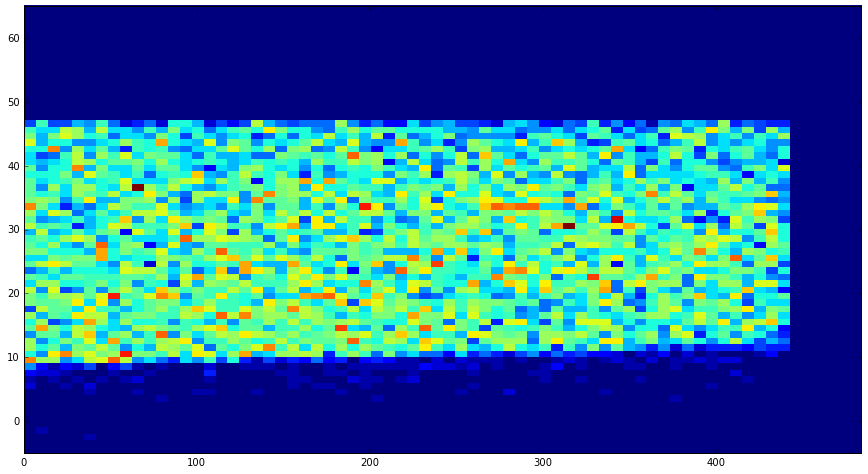

In [91]:
plt.figure(88)
plt.hist2d((datalist[zz]["x_real_s2"]**2+datalist[zz]["y_real_s2"]**2),datalist[zz]["z_real_s2"],\
               range=[[0,22.**2],[-5.,65.]],bins=(70,70), normed=True,label= datanamelist[zz])

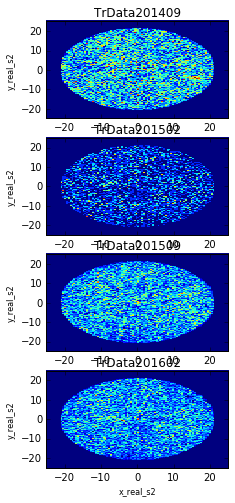

In [85]:
plt.figure(80)

#plt.plot(bandfits[2]*100.,bandfits[0],lw=4, color="g",label="LibNEST gaussian fit bins")
for zz in range(len(datanamelist)):
    ax0 = plt.subplot(4, 4, 4*zz+1)
#    plt.hist2d(traw_x_ts4,traw_y_ts4,range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= datanamelist[zz])
#    cbar = plt.colorbar()
    plt.hist2d(datalist[zz]["x_real_s2"],datalist[zz]["y_real_s2"],range=[[-25,25],[-25,25]],bins=(100,100), normed=True,label= datanamelist[zz])    
    plt.xlabel("x_real_s2",fontsize=8)
    plt.ylabel("y_real_s2",fontsize=8)
    plt.title(datanamelist[zz])

In [85]:
ts4.x_cm

array([[  23.24975586, -100.        ,    1.5924263 , ...,   14.8757515 ,
         -22.70432663,  -21.83454704],
       [  -1.0747788 , -100.        ,    0.87631005, ...,  -11.68109989,
        -100.        ,  -17.74773407],
       [-100.        , -100.        ,  -12.28910255, ..., -100.        ,
        -100.        , -100.        ],
       ..., 
       [-100.        ,   -4.25707006, -100.        , ...,   -6.41143942,
        -100.        , -100.        ],
       [   9.69697475,   -2.83490062,   10.8739109 , ...,   -6.09136534,
           5.48220968, -100.        ],
       [  10.05613518,   -3.01062036, -100.        , ...,   -9.28750038,
        -100.        , -100.        ]], dtype=float32)

In [82]:
sim

[]